We now consider a more complicated system than particle interaction-diatomic molecule interaction. In the molecular system, there is internal degree of freedom, which makes the whole system much more complicated to be predicted by NN. As we discussed before, we used COM frame to reduce the number of variables of the system by 3 properties, eg. 1) COM must lie on the line adjoining the two particle, 2)Velocity vectors for the two particles in COM coordinates are parallel at all time and 3) The magnitude of the velocity of each particle in CM coordinates is unchanged by the collision. We have to check if all properties are still conserved in the molecular system.

We first generate data of a interacting 2 molecules system. For the first molecule, the atom are placed at $r_{11} = (0,0.5)$ and $r_{12} = (0,-0.5)$ with velocity $v_{11} = (1.0,0.0)$ and $v_{12} = (0.0,0.0)$, while the atoms of the second molecule are placed at $r_{21} = (3.0,0.5)$ and $r_{22} = (3.0,-0.5)$ with velocity $v_{21} = (-0.8,0.0)$ and $v_{22} = (0.0,0.0)$. The short range interaction is $F_{SR} = 2d/(1+d^2)$ where $d$ is the separation between the atoms with cut-off separation $d_0=0.8$. For the bond of the molecule, it is given by $F_{bond} = C_{bond}(d - d_{bond,0})^2$ where $C_{bond}$ is the bond coefficient is $C_{bond} = 10$ and the equilibrium separation of bond is $d_{bond,0} = 1$.

In [1]:
import numpy as np

def leapfrog_integration(x_ini, v_ini, nop, dt, d0, pts, molecule=False, bond_neighbour=None):
  x = np.zeros((nop,pts,2))
  v = np.zeros((nop,pts,2))
  f = np.zeros((nop,pts,2))

  ### Compute the initial configuration of the system ###
  x[:,0] = x_ini
  v[:,0] = v_ini
  f_ins = instant_force(x_ini,d0,nop)
  f_ins = np.sum(f_ins,axis=1)
  f[:,0] = f_ins

  if molecule==True:
    f_bond = bond(x_ini, bond_neighbour,nop)
    f_bond = np.sum(f_bond,axis=1)
    f[:,0] += f_bond 

  for i in range(pts-1):
    ### Leapfrog integration ###
    x[:,i+1,:] = x[:,i,:] + v[:,i,:]*dt + 0.5*f[:,i,:]*dt*dt

    v_half_step = v[:,i,:] + 0.5*f[:,i,:]*dt

    f_ins = instant_force(x[:,i+1],d0,nop)
    f_ins = np.sum(f_ins,axis=1)
    f[:,i+1] = f_ins
    if molecule==True:
      f_bond = bond(x[:,i+1], bond_neighbour,nop)
      f_bond = np.sum(f_bond,axis=1)
      f[:,i+1] += f_bond

    v[:,i+1,:] = v_half_step + 0.5*f[:,i+1,:]*dt
  return x,v

def instant_force(x,d0,nop):
  ### This is the LJ interaction ###
  x = np.repeat(x[:,np.newaxis,:],nop,axis=1)
  x_T = np.swapaxes(x,0,1)
  d_xy = x - x_T

  d_self = np.sqrt(d_xy[:,:,0]**2. + (d_xy[:,:,1]**2.))
  d_self = np.reshape(d_self, [nop ** 2])

  off_diag_idx = np.ravel_multi_index(np.where(np.ones((nop, nop)) - np.eye(nop)), [nop, nop])
  d = d_self[off_diag_idx]
  d = np.reshape(d,(nop, nop - 1))
  d_resul = np.repeat(d[:,:,np.newaxis],2,axis=2)

  f = np.where(d<d0, 2.0*d/(1.0+d*d)/(1.0+d*d), 0)
  f = np.repeat(f[:,:,np.newaxis],2,axis=2)

  d_xy = np.reshape(d_xy, [nop * nop,2])
  d_xy = d_xy[off_diag_idx,:]
  d_xy = np.reshape(d_xy,(nop,nop - 1,2))
  f = f*d_xy/d_resul
  return f

def bond(x, bond_neighbour,nop):
  d0 = 1 		##	Equilibrium bond separation
  bc = 10		##	Bonding force constant
  x = np.repeat(x[:,np.newaxis,:],nop,axis=1)
  x_T = np.swapaxes(x,0,1)
  d_xy = x - x_T
  d_self = np.sqrt(d_xy[:,:,0]**2. + (d_xy[:,:,1]**2.))
  d_self = np.reshape(d_self, [nop ** 2])

  bond_neigbour_idx  = bond_neighbour[:,0]*nop + bond_neighbour[:,1]
  d = d_self[bond_neigbour_idx]
  d = np.repeat(d[:,np.newaxis],2,axis=1)
  f = -bc* (d - d0)

  d_xy = np.reshape(d_xy, [nop ** 2,2])
  d_xy = d_xy[bond_neigbour_idx,:]

  f = f*d_xy/d
  f_final = np.zeros((nop ** 2,2))
  f_final[bond_neigbour_idx] = f
  f_final = np.reshape(f_final,(nop,nop,2))
  return f_final

In [2]:
t = 10			              # Max time
pts = 1000		            # Number of point along the trajectory
dt = t/pts
pts += 1			            # Number of point + initial point

d0 = 0.8				          # Interaction radius 
nom = 2			              # no. of molecule
atom_per_mol = 2
nop = nom*atom_per_mol    # no. of particle

bond_neighbour = np.array([[0,1],[1,0],[2,3],[3,2]])	    # The neighbour for bond construction
  
x_ini = np.zeros((nop,2))
v_ini = np.zeros((nop,2))

### Set the initial state of the particle ###
x_ini[0] = np.array([0.0, 0.5])			# Position of the mol1 - particle1
x_ini[1] = np.array([0.0, -0.5])		# Position of the mol1 - particle2

v_ini[0] = np.array([1.0, 0.0])		# Velocity of the mol1 - particle1
v_ini[1] = np.array([0.0, 0.0])		# Velocity of the mol1 - particle1

x_ini[2] = np.array([3.0,0.5])		# Position of the mol2-particle 3
x_ini[3] = np.array([3.0,-0.5])		# Position of the mol2-particle 4
v_ini[2] = np.array([-0.8,0.0])		# velocity of the mol2-particle 3
v_ini[3] = np.array([0.0,0.0])		# velocity of the mol2-particle 4

r,v = leapfrog_integration(x_ini, v_ini, nop, dt, d0, pts, molecule=True, bond_neighbour=bond_neighbour)

Then we can analysis the result of it.

In [3]:
def COM_frame(r, v):
  ###	Dimension is (nop, pts, dim)  ####
  R1 = (r[0,:,:] + r[1,:,:])/2 		# position of COM - mol1
  R2 = (r[2,:,:] + r[3,:,:])/2 		# position of COM - mol2
  R = (R1 + R2)/2

  V1 = (v[0,:,:] + v[1,:,:])/2 		# position of COM - mol1
  V2 = (v[2,:,:] + v[3,:,:])/2 		# position of COM - mol2
  V = (V1 + V2)/2

  r_com = r - R[None,:,:]
  v_com = v - V[None,:,:]

  R1_com = R1 - R
  R2_com = R2 - R

  V1_com = V1 - V
  V2_com = V2 - V
  return r_com, v_com, R, V, R1, R2, V1, V2, R1_com, R2_com, V1_com, V2_com

def angular_velocity(r, v, R1, R2, V1, V2):
  d1 = r[:2,:,:] - R1
  d2 = r[2:,:,:] - R2

  v1 = v[:2,:,:] - V1
  v2 = v[2:,:,:] - V2

  mag_sq_d1 = np.sum(np.square(d1),axis=-1)
  mag_sq_d2 = np.sum(np.square(d2),axis=-1)

  w1 = np.cross(d1, v1)/mag_sq_d1
  w2 = np.cross(d2, v2)/mag_sq_d2

  I1 = np.sum(mag_sq_d1,axis=0)
  I2 = np.sum(mag_sq_d2,axis=0)

  KE_rot1 = 0.5 * I1 * np.square(w1[0])
  KE_rot2 = 0.5 * I2 * np.square(w2[0])

  KE_trans1 = 0.5 *  np.sum(np.square(V1),axis=-1) *2
  KE_trans2 = 0.5 *  np.sum(np.square(V2),axis=-1) *2
  return w1, w2, KE_rot1, KE_rot2, KE_trans1, KE_trans2

def bond_energy(r,v,bc,R1,R2,V1,V2):
  d1 = r[:2,:,:] - R1
  d2 = r[2:,:,:] - R2
  v1 = v[:2,:,:] - V1
  v2 = v[2:,:,:] - V2

  mag_d1 = np.sqrt(np.sum(np.square(d1),axis=-1))
  mag_d2 = np.sqrt(np.sum(np.square(d2),axis=-1))

  v1_r = (d1[:,:,0]*v1[:,:,0] + d1[:,:,1]*v1[:,:,1])/mag_d1
  v2_r = (d2[:,:,0]*v2[:,:,0] + d2[:,:,1]*v2[:,:,1])/mag_d2
  KE_bond1 = 0.5 * np.sum(np.square(v1_r),axis=0)
  KE_bond2 = 0.5 * np.sum(np.square(v2_r),axis=0)

  KE_1 = 0.5 * np.sum(np.sum(np.square(v1),axis=-1),axis=0)
  KE_2 = 0.5 * np.sum(np.sum(np.square(v2),axis=-1),axis=0)

  d1_12 = np.sqrt(np.sum(np.square(d1[0,:,:] - d1[1,:,:]),axis=-1))
  d2_12 = np.sqrt(np.sum(np.square(d2[0,:,:] - d2[1,:,:]),axis=-1))

  PE_bond1 = 0.5 * bc * np.square(d1_12 - 1.0)
  PE_bond2 = 0.5 * bc * np.square(d2_12 - 1.0)
  return KE_1, KE_2, PE_bond1, PE_bond2, KE_bond1, KE_bond2

In [4]:
bc = 10
r_com, v_com, R, V, R1, R2, V1, V2, R1_com, R2_com, V1_com, V2_com = COM_frame(r, v)
w1 ,w2, KE_rot1, KE_rot2, KE_trans1, KE_trans2 = angular_velocity(r_com, v_com, R1_com, R2_com, V1_com, V2_com)
KE_1, KE_2, PE_bond1, PE_bond2, KE_bond1, KE_bond2 = bond_energy(r_com,v_com,bc, R1_com, R2_com, V1_com, V2_com)

In the following, we visualize the interaction between 2 molecules in both normal frame and COM frame.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


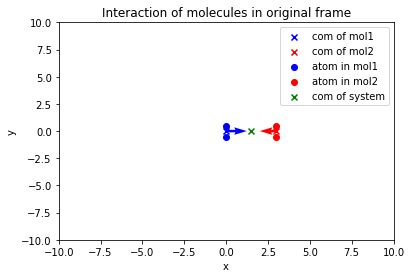

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

frames = len(r[0])
#dt = 0.001
t = np.arange(frames )*dt
fig, ax = plt.subplots()

def update_normal(i):
  ax.clear()
  v_vector = np.array([V1[i], V2[i]])
  origin = np.array([[R1[i,0], R2[i,0]],[[R1[i,1], R2[i,1]]]]) # origin point
  plt.quiver(*origin, v_vector[:,0], v_vector[:,1], color=['b','r'])

  ax.scatter(R1[i,0], R1[i,1], c='b', marker='x', label='com of mol1')
  ax.scatter(R2[i,0], R2[i,1], c='r', marker='x',label='com of mol2')
  ax.scatter(r[:2,i,0], r[:2,i,1], c='b',label='atom in mol1')
  ax.scatter(r[2:,i,0], r[2:,i,1], c='r',label='atom in mol2')
  ax.scatter(R[i,0], R[i,1], c='g', marker='x',label='com of system')

  ax.set_xlim(-10, 10)
  ax.set_ylim(-10, 10)

  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title('Interaction of molecules in original frame')
  ax.legend()

ani = animation.FuncAnimation(fig, update_normal, frames=frames, interval=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


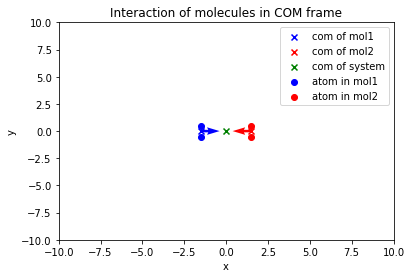

In [6]:
fig, ax = plt.subplots()
def update_com(i):
  ax.clear()
  v_vector = np.array([V1_com[i], V2_com[i]])
  origin = np.array([[R1_com[i,0], R2_com[i,0]],[[R1_com[i,1], R2_com[i,1]]]]) # origin point
  plt.quiver(*origin, v_vector[:,0], v_vector[:,1], color=['b','r'])

  ax.scatter(R1_com[i,0], R1_com[i,1], c='b', marker='x', label='com of mol1')
  ax.scatter(R2_com[i,0], R2_com[i,1], c='r', marker='x',label='com of mol2')

  ax.scatter(0, 0, c='g', marker='x',label='com of system')

  ax.scatter(r_com[:2,i,0], r_com[:2,i,1], c='b',label='atom in mol1')
  ax.scatter(r_com[2:,i,0], r_com[2:,i,1], c='r',label='atom in mol2')

  ax.set_xlim(-10, 10)
  ax.set_ylim(-10, 10)

  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title('Interaction of molecules in COM frame')
  ax.legend()

ani = animation.FuncAnimation(fig, update_com, frames=frames, interval=100)

We then test if the 3 properties of COM frame are still conserved in the molecular system. The first property is to test if the postion of the COM of 2 molecules are always opposite to each other.

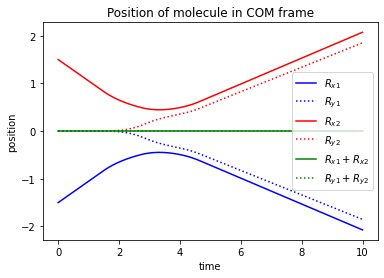

In [7]:
### Test for if position always opposite ###
plt.plot(t,R1_com[:,0], c='b', label='$R_{x1}$')
plt.plot(t,R1_com[:,1], c='b', ls='dotted', label='$R_{y1}$')
plt.plot(t,R2_com[:,0], c='r', label='$R_{x2}$')
plt.plot(t,R2_com[:,1], c='r', ls='dotted', label='$R_{y2}$')
plt.plot(t,R1_com[:,0]+R2_com[:,0], c='g', label='$R_{x1}+R_{x2}$')
plt.plot(t,R1_com[:,1]+R2_com[:,1], c='g', ls='dotted', label='$R_{y1}+R_{y2}$')
plt.xlabel('time')
plt.ylabel('position')
plt.title('Position of molecule in COM frame')

plt.legend()
plt.show()

Therefore, we can see that the COM of  2 molecules are always opposite to each other in COM frame.

For the next property, we test for if the velocity of two molecules are always opposite to each other.

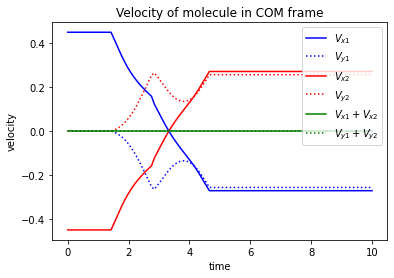

In [8]:
### Test for if velocity always opposite ###
plt.plot(t,V1_com[:,0], c='b', label='$V_{x1}$')
plt.plot(t,V1_com[:,1], c='b', ls='dotted', label='$V_{y1}$')
plt.plot(t,V2_com[:,0], c='r', label='$V_{x2}$')
plt.plot(t,V2_com[:,1], c='r', ls='dotted', label='$V_{y2}$')
plt.plot(t,V1_com[:,0]+V2_com[:,0], c='g', label='$V_{x1}+V_{x2}$')
plt.plot(t,V1_com[:,1]+V2_com[:,1], c='g', ls='dotted', label='$V_{y1}+V_{y2}$')
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('Velocity of molecule in COM frame')

plt.legend()
plt.show()

From the above graph, we can see that the velocity of 2 molecules are always opposite to each other.

For the last properties, we want to see if the velocity of the molecules are unchanged after interaction.

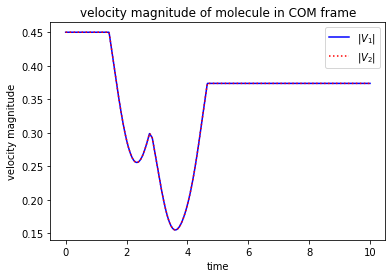

In [9]:
## Test for if velocity unchange after collision ##
plt.plot(t, (np.sqrt(V1_com[:,0]**2 + V1_com[:,1]**2)), c='b', label='|$V_{1}|$')
plt.plot(t, (np.sqrt(V2_com[:,0]**2 + V2_com[:,1]**2)), c='r', ls='dotted', label='|$V_{2}|$')
plt.xlabel('time')
plt.ylabel('velocity magnitude')
plt.title('velocity magnitude of molecule in COM frame')

plt.legend()
plt.show()

So we can see that the velocity is changed after interaction. But where does the kinectic energy go? One of the possibility is the energy is transfered to the internal energy of the molecule, eg. angular kinetic energy of the molecule $KE_{rot} = \frac{1}{2} I ω^2$.

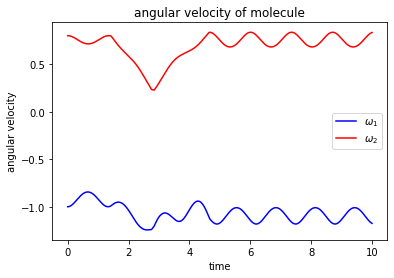

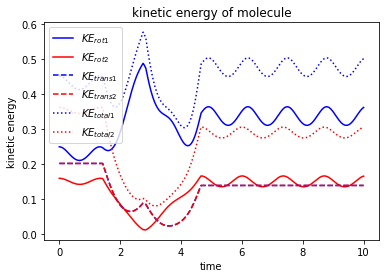

In [10]:
### Test for angular velocity ###
plt.plot(t,w1[0], c='b', label='$\omega_{1}$')
plt.plot(t,w2[0], c='r', label='$\omega_{2}$')
plt.xlabel('time')
plt.ylabel('angular velocity')
plt.title('angular velocity of molecule')

plt.legend()
plt.show()

### Test for kinectic energy ###
plt.plot(t,KE_rot1, c='b', label='$KE_{rot1}$')
plt.plot(t,KE_rot2, c='r', label='$KE_{rot2}$')
plt.plot(t,KE_trans1, c='b', ls='dashed', label='$KE_{trans1}$')
plt.plot(t,KE_trans2, c='r', ls='dashed', label='$KE_{trans2}$')
plt.plot(t,KE_rot1 + KE_trans1, c='b', ls='dotted', label='$KE_{total1}$')
plt.plot(t,KE_rot2 + KE_trans2, c='r', ls='dotted', label='$KE_{total2}$')
plt.xlabel('time')
plt.ylabel('kinetic energy')
plt.title('kinetic energy of molecule')

plt.legend()
plt.show()

In the above graph, this show the angular kinetic energy of the molcule. We can see that the sum of translational kinetic energy and the angular kinectic energy does not conserve throughout the interaction. Moreover, the angular kinetic energy also does not conserve even there is no interaction. There should be some other internal energy of the molecules, eg. the KE of the atom along the bond direction and PE stored in bond.

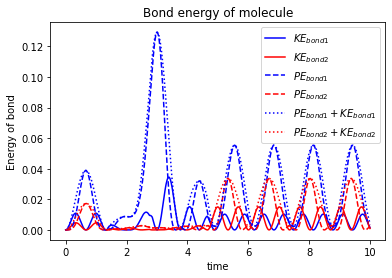

In [11]:
### Test for Bond energy ###
plt.plot(t,KE_bond1, c='b', label='$KE_{bond1}$')
plt.plot(t,KE_bond2, c='r', label='$KE_{bond2}$')
plt.plot(t,PE_bond1, c='b', ls='dashed', label='$PE_{bond1}$')
plt.plot(t,PE_bond2, c='r', ls='dashed', label='$PE_{bond2}$')
plt.plot(t,KE_bond1 + PE_bond1, c='b', ls='dotted', label='$PE_{bond1}+KE_{bond1}$')
plt.plot(t,KE_bond2 + PE_bond2, c='r', ls='dotted', label='$PE_{bond2}+KE_{bond2}}$')
plt.xlabel('time')
plt.ylabel('Energy of bond')
plt.title('Bond energy of molecule')

plt.legend()
plt.show()

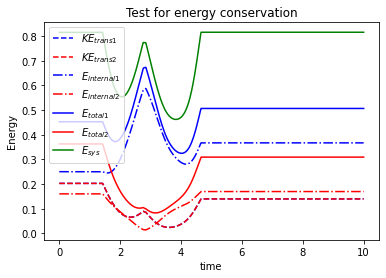

In [12]:
### Test for energy conservation ###
plt.plot(t,KE_trans1, c='b', ls='dashed', label='$KE_{trans1}$')
plt.plot(t,KE_trans2, c='r', ls='dashed', label='$KE_{trans2}$')
plt.plot(t,KE_bond1+KE_rot1+PE_bond1, c='b', ls='dashdot', label='$E_{internal1}$')
plt.plot(t,KE_bond2+KE_rot2+PE_bond2, c='r', ls='dashdot', label='$E_{internal2}$')
plt.plot(t,KE_trans1+KE_bond1+KE_rot1+PE_bond1, c='b', label='$E_{total1}$')
plt.plot(t,KE_trans2+KE_bond2+KE_rot2+PE_bond2, c='r', label='$E_{total2}$')
plt.plot(t,KE_trans1+KE_bond1+KE_rot1+PE_bond1+KE_trans2+KE_bond2+KE_rot2+PE_bond2, c='g', label='$E_{sys}$')
plt.xlabel('time')
plt.ylabel('Energy')
plt.title('Test for energy conservation')

plt.legend()
plt.show()

In the last graph, it shows the energy conservation of the system. The internal energy is the sum of rotational energy, bond kinetic energy and bond potential energy $E_{internal} = KE_{rot} + KE_{bond} + PE_{bond}$ and the total energy of a molecule is the sum of translational kinetic energy of its COM and its internal energy $E_{mol} = KE_{trans} + E_{internal}$. The green line shows the total energy of system, which is the the sum of total energy of molecule 1 and molecule 2. There is a drop of the green line due to the part of the energy transfered to the PE of Lennard-Jones interaction, but the total energy is conserved before and after the interaction.

In 2 particles system, we can compute the particle trajectory exactly before the interaction. However, this is not the same for moelcular system even though the internal energy is constant before interaction. The rotational energy and vibrational energy of the molecule are always exchanging, eg. it is like a rotating spring. In order to obtain the equation of motion, we have to write the Langrangian of the rotating molecule:
$$L = T-V = 2(\frac{1}{2}mv^2)-\frac{1}{2}k(d-d_0)^2$$
The factor of 2 in KE is because of the 2 atom, $d$ is the separation of the atom and $d_0$ is the equilibrium position of the bond.
We then write the Langragian in polar coordinate:
$$L = m(\dot{r}^2 + (r \dot{\theta})^2)- \frac{1}{2} k(2r-2r_0)^2$$
$$L = m(\dot{r}^2 + (r \dot{\theta})^2)- 2 k(r-r_0)^2$$
where we set the origin is (0,0), r is the position of 1 atom such that $d = 2r$ and $d_0 = 2r_0$ and.

Then, we can write the equation of motion along radial direction:
$$\frac{d}{dt}(\frac{∂L}{∂\dot{r}}) = \frac{∂L}{∂r} $$
$$ \ddot{r} =  r \dot{\theta}^2 - k'(r-r_0)$$
where $k'$ is the resultant bond coefficient $k'=2k$ and $m=1$.
Also, we can write the equation of motion along tangential direction:
$$\frac{d}{dt}(\frac{∂L}{∂\dot{\theta}}) = \frac{∂L}{∂\theta} $$
$$ r \ddot{\theta} + 2 \dot{r} \dot{\theta} = 0$$
Due to no external force, angular momemtum is conserved, eg.
$$l = mrv_{\perp}=mr^2\dot{\theta}$$
$$\dot{\theta} = \frac{l}{mr^2}$$
Therefore, the radial EOM can be rewritten as:
$$ \ddot{r} =  \frac{l^2}{r^3} - k'(r-r_0)$$

Since we just want to get the trajectory/internal state of the molecule before interaction, we just use the same intial state as before, the only difference is that the velocity is along the opposite direction.

In [13]:
x_ini = np.zeros((nop,2))
v_ini = np.zeros((nop,2))

### Set the initial state of the particle ###
x_ini[0] = np.array([0.0, 0.5])			# Position of the mol1 - particle1
x_ini[1] = np.array([0.0, -0.5])		# Position of the mol1 - particle2

v_ini[0] = np.array([-1.0, 0.0])		# Velocity of the mol1 - particle1
v_ini[1] = np.array([0.0, 0.0])		# Velocity of the mol1 - particle1

x_ini[2] = np.array([3.0,0.5])		# Position of the mol2-particle 3
x_ini[3] = np.array([3.0,-0.5])		# Position of the mol2-particle 4
v_ini[2] = np.array([0.8,0.0])		# velocity of the mol2-particle 3
v_ini[3] = np.array([0.0,0.0])		# velocity of the mol2-particle 4

r,v = leapfrog_integration(x_ini, v_ini, nop, dt, d0, pts, molecule=True, bond_neighbour=bond_neighbour)

In [14]:
bc = 10
r_com, v_com, R, V, R1, R2, V1, V2, R1_com, R2_com, V1_com, V2_com = COM_frame(r, v)

In [15]:
def radial_and_tangential_x_v(r, v, R1, R2, V1, V2):
  d1 = r[:2,:,:] - R1
  d2 = r[2:,:,:] - R2
  v1 = v[:2,:,:] - V1
  v2 = v[2:,:,:] - V2

  mag_d1 = np.sqrt(np.sum(np.square(d1),axis=-1))
  mag_d2 = np.sqrt(np.sum(np.square(d2),axis=-1))

  v1_r = (d1[:,:,0]*v1[:,:,0] + d1[:,:,1]*v1[:,:,1])/mag_d1
  v2_r = (d2[:,:,0]*v2[:,:,0] + d2[:,:,1]*v2[:,:,1])/mag_d2
  d1_12 = np.sqrt(np.sum(np.square(d1[0,:,:] - d1[1,:,:]),axis=-1))
  d2_12 = np.sqrt(np.sum(np.square(d2[0,:,:] - d2[1,:,:]),axis=-1))

  w1 = np.cross(d1, v1)/np.square(mag_d1)
  w2 = np.cross(d2, v2)/np.square(mag_d2)
  v1_p = np.cross(d1, v1)/mag_d1
  v2_p = np.cross(d2, v2)/mag_d2
  return v1_r, v2_r, d1_12, d2_12, w1, w2, v1_p, v2_p

v1_r, v2_r, d1, d2, w1, w2, v1_p, v2_p = radial_and_tangential_x_v(r_com, v_com, R1_com, R2_com, V1_com, V2_com)

As we want to test if radial EOM is correct, we can just compute a numerical test for the radial EOM by comparing the result getting from the molecular system. The following is the numerical test for radial EOM by evolving the atom1 in molecule1 by giving its intial state.

In [16]:
def test_func(x,l0,k_resul,d0):
  a = ((l0)**2)/(x**3) - k_resul*(x-d0)
  return a

def numerical_sol(x0,v0,vp,l0,k_resul,d0, dt, pts):
  x_save = np.zeros((pts))
  v_save = np.zeros((pts))
  a0 = test_func(x0,l0,k_resul,d0)

  x_save[0] = x0
  v_save[0] = v0

  for i in range(pts-1):
    x = x0 + v0*dt + 0.5*a0*dt*dt
    v_half = v0 + 0.5*a0*dt
    a = test_func(x,l0,k_resul,d0)
    v = v_half + 0.5*a*dt

    x0 = x
    v0 = v
    a0 = a
    x_save[i+1] = x
    v_save[i+1] = v
  return x_save,v_save

In [17]:
x0 = d1[0]/2		## Initial separation
v0 = v1_r[0,0]		## Initial velocity along radial direction
vp = v1_p[0,0]		## Initial velocity along tangential direction
l0 = x0*vp			## Angular momentum --> this does not change througout rotation
w = vp/x0			## Angular velocity
k = 10				## Spring const
k_resul = 2*k		## Resultant spring constant due to 2 mass spring system
d0 = 0.5			## Equilibrium position of mass

x_num, v_num = numerical_sol(x0,v0,vp,l0,k_resul,d0,dt,pts)

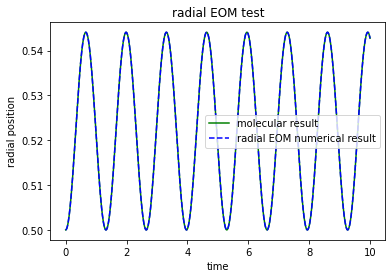

In [18]:
### Test for radial EOM ###
plt.plot(t,d1/2, c='g', label='molecular result')
plt.plot(t,x_num, c='b', ls='dashed', label='radial EOM numerical result')
plt.xlabel('time')
plt.ylabel('radial position')
plt.title('radial EOM test')
plt.legend()
plt.show()

So we can see that the radial EOM result is exactly on top of the curve of the molecular result. Radial EOM is correct. However, we are still doing computation of time evolution of the system, we would like to see if we are possible to solve the radial EOM analytically. And from this we could save a lot of computational step of doing this.

From the radial EOM,
$$ \ddot{r} =  \frac{l^2}{r^3} - k'(r-r_0) $$
on the right hand side the first term is centrifugal force due to the rotation of the molecule, while the second term is the force term due to bond of molecule. Due to the rotation of the molecule, the centrifugal force would push the atom away from its COM. Therefore, the centrifugal force push the atoms away from center while the bond pull the atoms towards the center. There exist a resultant equilibrium of the bond, such that the centrifugal force is balanced by the force of bond, eg. $\ddot{r}=0$
$$\frac{l^2}{r^3} = k'(r-r_0) $$
$$r^4 - r_0 r^3 - \frac{l^2}{k} = 0 $$
And we could solve this polymial in numpy, and we called the root of this polymial as $r'$. Then we could rewrite the radial EOM with $r'$,
$$ \ddot{r} =  \frac{l^2}{r^3} - k'(r-r') - k'(r'-r_0) $$
$$ \ddot{r} =  \frac{l^2}{r^3} - \frac{l^2}{r'^3} - k'(r-r') $$
$$ \ddot{r} =  l^2(\frac{r'^3 - r^3}{r^3r'^3}) - k'(r-r') $$
$$ \ddot{r} =  l^2(\frac{(r'-r)(r'^2+r'r+r^2)}{r^3r'^3}) - k'(r-r')$$
Then we can set $ξ = r-r' $
Therefore, we can rewrite the equation
$$ \ddot{ξ} = -(l^2 \frac{ξ^2+2ξr'+r'^2+ξr'+r'^2+r'2}{(ξ+r')^3r'^3} - k')(r-r')$$
$$ \ddot{ξ} = -(l^2 \frac{ξ^2+3ξr'+3r'^2}{(ξ+r')^3r'^3} - k')(r-r')$$
$$ \ddot{ξ} = -(l^2 \frac{r'^2((\frac{ξ}{r'})^2+3(\frac{ξ}{r'})+3}{r'^3((\frac{ξ}{r})+ 1)^3r'^3} - k')(r-r')$$
Since $ξ$ is the variation of atom position along radial direction and $r'$ is the resultant equilibrium position, we assume that $ξ \ll r'$ and $\frac{ξ}{r'}\ll 1$. Then we can approximate the equation,
$$ \ddot{ξ} = -(\frac{3 l^2}{r'^4} - k')(r-r')$$

And we can finally get the approximated solution of the radial EOM.

In [19]:
import math
def analytical_sol(x0,v0,vp,l0,k_resul,d0, dt, pts):
  coeff = [1,-d0,0,0,-l0**2/k_resul]
  roots = np.roots(coeff)
  roots = roots[np.isreal(roots)]
  roots = roots[roots > d0]
  d0_new = np.min(np.real(roots))
  k_new = 3 * l0**2. /  d0_new**4. + k_resul

  w = math.sqrt(k_new)
  t = np.arange(pts)*dt
  #x = -0.022*np.cos(w*t)  + 0.522
  ### Using ansatz x - d0_new = A sin(wt + phi) #################
  ### and ansatz of velocity v = wcos(wt + phi) #################
  ### and solve A and phi by using initial condition x0,v0 ######
  phi = math.atan( (x0 - d0_new)/w/v0)
  A = math.sqrt((x0 - d0_new)**2. + (v0/w)**2.)

  x = A * np.sin(w*t + phi) + d0_new
  v = A * w * np.cos(w*t + phi)
  return x, v

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


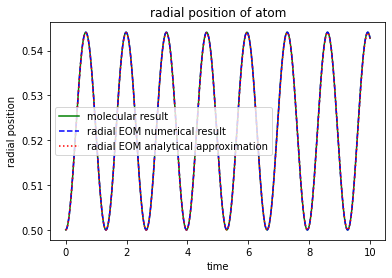

In [20]:
x_ana, v_ana = analytical_sol(x0,v0,vp,l0,k_resul,d0,dt,pts)
plt.plot(t,d1/2, c='g', label='molecular result')
plt.plot(t,x_num, c='b', ls='dashed', label='radial EOM numerical result')
plt.plot(t,x_ana, c='r',  ls='dotted', label='radial EOM analytical approximation')
plt.xlabel('time')
plt.ylabel('radial position')
plt.title('radial position of atom')

plt.legend()
plt.show()

We can see that the analytical approximated solution is also on top on the numerical result. The next step is to test the angular velocity of it.

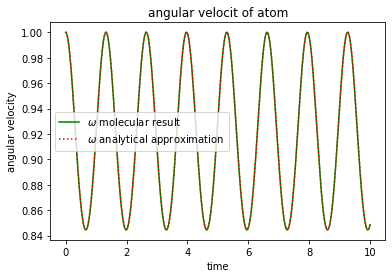

In [21]:
w_ana = l0/x_ana**2
plt.plot(t,w1[0], c='g', label='$\omega$ molecular result')
plt.plot(t,w_ana, c='r',  ls='dotted', label='$\omega$ analytical approximation')
plt.xlabel('time')
plt.ylabel('angular velocity')
plt.title('angular velocit of atom')

plt.legend()
plt.show()

We can also see that the approximated angular velocity also fit to the molecular result. However, we have approximated the radial EOM by assuming $\frac{ξ}{r'}\ll 1$. When the angular momemtum is large, the resultant equilibrium position $ξ$ is larger as it requires long bond elongation to balance the centrifugal force. For example, if I increase the initial velocity of atom1 in molecule1 from -1 to -4, we can see the difference in the following:

In [22]:
x_ini = np.zeros((nop,2))
v_ini = np.zeros((nop,2))

### Set the initial state of the particle ###
x_ini[0] = np.array([0.0, 0.5])			# Position of the mol1 - particle1
x_ini[1] = np.array([0.0, -0.5])		# Position of the mol1 - particle2

v_ini[0] = np.array([-2.0, 0.0])		# Velocity of the mol1 - particle1
v_ini[1] = np.array([0.0, 0.0])		# Velocity of the mol1 - particle1

x_ini[2] = np.array([3.0,0.5])		# Position of the mol2-particle 3
x_ini[3] = np.array([3.0,-0.5])		# Position of the mol2-particle 4
v_ini[2] = np.array([0.8,0.0])		# velocity of the mol2-particle 3
v_ini[3] = np.array([0.0,0.0])		# velocity of the mol2-particle 4

r,v = leapfrog_integration(x_ini, v_ini, nop, dt, d0, pts, molecule=True, bond_neighbour=bond_neighbour)
bc = 10
r_com, v_com, R, V, R1, R2, V1, V2, R1_com, R2_com, V1_com, V2_com = COM_frame(r, v)
v1_r, v2_r, d1, d2, w1, w2, v1_p, v2_p = radial_and_tangential_x_v(r_com, v_com, R1_com, R2_com, V1_com, V2_com)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


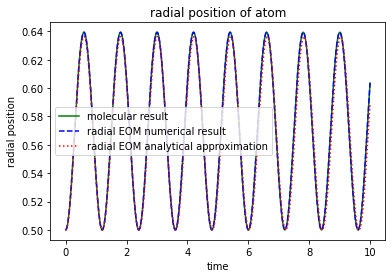

In [23]:
x0 = d1[0]/2		## Initial separation
v0 = v1_r[0,0]		## Initial velocity along radial direction
vp = v1_p[0,0]		## Initial velocity along tangential direction
l0 = x0*vp			## Angular momentum --> this does not change througout rotation
w = vp/x0			## Angular velocity
k = 10				## Spring const
k_resul = 2*k		## Resultant spring constant due to 2 mass spring system
d0 = 0.5			## Equilibrium position of mass

x_num, v_num = numerical_sol(x0,v0,vp,l0,k_resul,d0,dt,pts)
x_ana, v_ana = analytical_sol(x0,v0,vp,l0,k_resul,d0,dt,pts)

plt.plot(t,d1/2, c='g', label='molecular result')
plt.plot(t,x_num, c='b', ls='dashed', label='radial EOM numerical result')
plt.plot(t,x_ana, c='r',  ls='dotted', label='radial EOM analytical approximation')
plt.xlabel('time')
plt.ylabel('radial position')
plt.title('radial position of atom')

plt.legend()
plt.show()